In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 1.9MB 11.7MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aa9ca765ed5aa5bc4118a5baed7898911f5f1d346093e050d51a04bba9b4b8a0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.1MB/s 


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)

project_dir = './drive/MyDrive/WASSA/'

In [ ]:
! nvidia-smi

Wed Mar  3 13:07:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preprocessing

In [ ]:
train_df = pd.read_csv(project_dir + 'train.tsv', sep='\t')
train_df.head()

,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,education,race,age,income,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
3,R_1hGrPtWM4SumG0U_4,R_1hGrPtWM4SumG0U,290,4.167,5.250,1,1,it is frightening to learn about all these sha...,fear,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
4,R_1hGrPtWM4SumG0U_5,R_1hGrPtWM4SumG0U,342,5.333,4.625,1,1,the eldest generation of russians aren't being...,sadness,1,4,1,33,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0


In [ ]:
# preprocessing
def clean_abstract(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    texts = df['essay'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels=[]
    for i in range(len(df)):
      label = df.iloc[i,8]
      labels.append(label + ' </s>')
    return labels

texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	it is really diheartening to read about these immigrants from this article who drowned .  it makes me feel anxious and upset how the whole ordeal happened .  it is a terrible occurrence that this had to happen at the mediterranean sea .  thankfully there were some survivors .  the fact that babies were lost makes it that much more emotional to read all of this
LABEL -	sadness </s>

TEXT -	the phone lines from the suicide prevention line surged after the election .  it also climbed when robin williams committed suciide .  thankfully there is this prevention line to help those in need who have sucidal thoughts but we need to condition people that committing sucide is a permanent solution to a temporary problem
LABEL -	sadness </s>

TEXT -	no matter what your heritage ,  you should be able to serve your country .  her thai heritage shouldn't preclude her and shouldn't have been an issue in this debate .  tammy duckworth and her family should be congratulated on the services they ha

# Exploratory Data Analysis

<BarContainer object of 1860 artists>

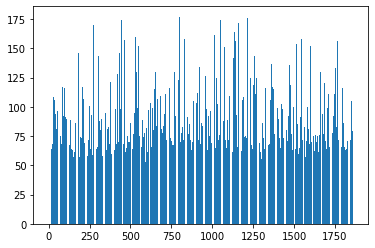

In [ ]:
# text lengths
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

# Config

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'mrm8488/t5-base-finetuned-emotion'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 320
        self.TGT_MAX_LENGTH = 2
        self.BATCH_SIZE = 8
        self.VALIDATION_SPLIT = 0.10

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 10

config = Config()

# Dataset & Dataloader

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [ ]:
# train-val split

np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
train_data = T5Dataset(train_df, train_indices)
val_data = T5Dataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE, shuffle = False)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([8, 320])
src_attention_mask shape: torch.Size([8, 320])
tgt_input_ids shape: torch.Size([8, 2])
tgt_attention_mask shape: torch.Size([8, 2])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

In [ ]:
device = config.DEVICE
device

device(type='cuda')

# Engine

Our engine consists of the training and validation step functions.

In [ ]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import f1_score
le = LE()
le.fit(train_df['emotion']) 

LabelEncoder()

In [ ]:
def get_ohe(pred_ohe):
    ans = []
    for i in range(len(pred_ohe)):
      if '<pad>' in pred_ohe[i]:
        ans.append(pred_ohe[i].split(' ')[1].split("</s>")[0])
      else:
        ans.append(pred_ohe[i].split("</s>")[0])
    a = list(set(train_df['emotion']))
    for i in range(len(ans)):
      if ans[i] not in a: # if Label token is incorrectly generated, classify as neutral label, required in intial step of training
        ans[i]='neutral'
    return ans

In [ ]:
from sklearn.metrics import f1_score
def f1_score_calc(pred, true):
  y_true = le.transform(true)
  y_pred = le.transform(pred)
  return f1_score(y_true, y_pred, average='macro')

In [ ]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)


    print(pred[0], true[0])
    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)

    score = f1_score_calc(get_ohe(pred), get_ohe(true))
    print('Val macro f1 score:', score)
    return score


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

In [ ]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_macro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_macro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_macro_f1_score > max_val_macro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_macro_f1_score = val_macro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_macro_f1_score} -> {val_macro_f1_score}')
                max_val_macro_f1_score = val_macro_f1_score

    return best_model, best_val_macro_f1_score

In [ ]:
model = T5Model()
model.to(device);

In [ ]:
best_model, best_val_micro_f1_score = run()

# Prediction

In [ ]:
test_df = pd.read_csv(project_dir + 'dev.tsv', sep='\t')
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = T5Dataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [ ]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    return pred

pred_ohe = predict(model)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
pred_ohe[0]

'<pad> sadness</s>'

In [ ]:
pred_ohe[0].split('<pad> ')[1].split("</s>")[0]

'sadness'

In [ ]:
ans = get_ohe(pred_ohe)

In [ ]:
df = pd.read_csv(project_dir + 'ground.tsv', sep='\t', names=["empathy", "distress", 'emotion'])

In [ ]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import f1_score
le = LE()
le.fit(train_df['emotion']) 

LabelEncoder()

In [ ]:
from sklearn.metrics import f1_score
def f1_score_calc(pred):
  y_true = le.transform(df['emotion'])
  y_pred = le.transform(pred)
  return f1_score(y_true, y_pred, average='macro')


In [ ]:
f1_score_calc(ans)

0.5722085171064764

# Submission

In [ ]:
test_df = pd.read_csv(project_dir + 'test.tsv', sep='\t')
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = T5Dataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [ ]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    return pred

pred_ohe = predict(model)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
ans = get_ohe(pred_ohe)

In [ ]:
test_sub = pd.DataFrame({'ds':ans})
test_ans = test_sub.to_csv("./predictions_EMO.tsv",sep='\t',index=False,header=None)